# Effective Kraus Rank

In [19]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [20]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 2
d = 2**n
rank_list = np.array([i+1 for i in range(d**2)])

rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(100):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               spam = spam_model,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff/100)

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\krisw\AppData\Local\Temp\ipykernel_22808\2999238667.py:7: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001F382CA02E0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Effective Rank", "2^log2(rank)/2", "Rank_eff = 8"])


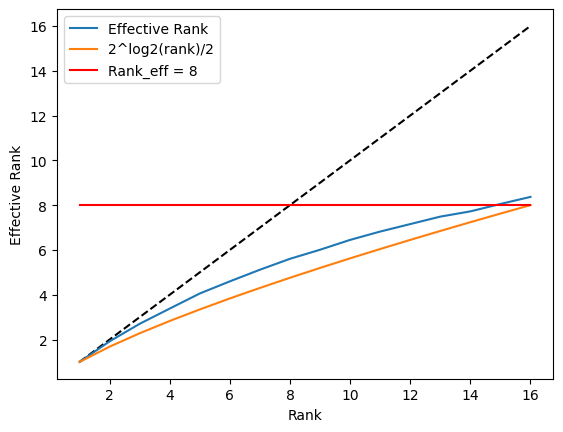

In [29]:
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
plt.plot(rank_list, y)
plt.plot([1, 16], [8, 8], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "2^log2(rank)/2", "Rank_eff = 8"])
plt.show()

In [53]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 3
d = 2**n
rank_list = np.array([i+1 for i in range(d**2)])
rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(10):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               spam = spam_model,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff/10)

  0%|          | 0/64 [00:00<?, ?it/s]

C:\Users\krisw\AppData\Local\Temp\ipykernel_9144\2945395442.py:6: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x00000246D5B86D40> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Effective Rank", "Rank_eff = 32"])


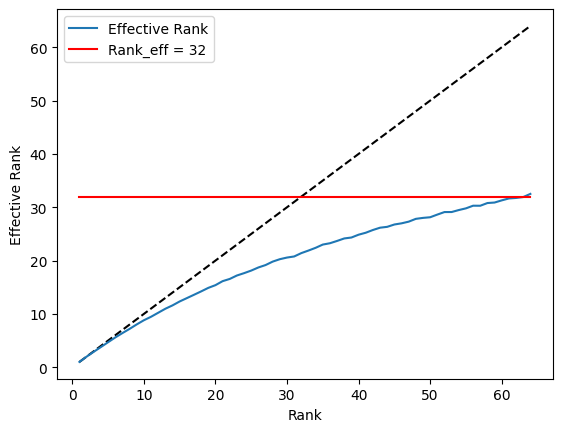

In [54]:
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
plt.plot([1, 64], [32, 32], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "Rank_eff = 32"])
plt.show()

In [55]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
n = 4
d = 2**n
rank_list = [i+1 for i in range(d**2)]
rank_eff_list = []
for i in tqdm(rank_list):
    rank_eff = 0
    for j in range(1):
        kraus_model = KrausMap(
                               d = d, 
                               rank = i,
                               spam = spam_model,
                               )
        rank_eff += effective_rank(kraus_model)
    rank_eff_list.append(rank_eff/1)

  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\krisw\AppData\Local\Temp\ipykernel_9144\3791723038.py:6: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x00000246D5B973A0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Effective Rank", "Rank_eff = 128"])


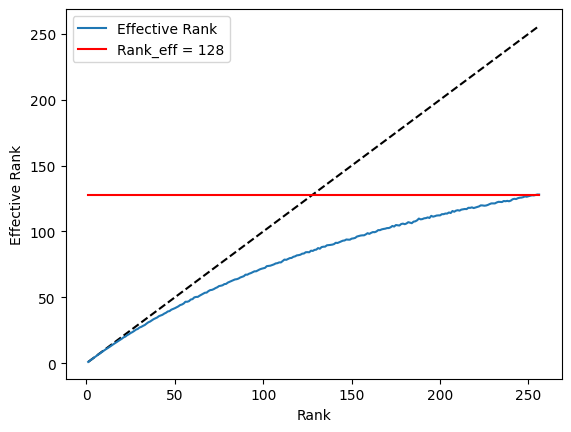

In [56]:
plt.plot(rank_list, rank_list, "k--")
plt.plot(rank_list, rank_eff_list)
plt.plot([1, 256], [128, 128], "r")
plt.xlabel("Rank")
plt.ylabel("Effective Rank")
plt.legend(["_", "Effective Rank", "Rank_eff = 128"])
plt.show()

## Synthetic Benchmark

### Generate Ground Truth

In [33]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = d
c1 = 0.9
c2 = 0.9

#prep error and full POVM error
spam_target = SPAM(d=d)

init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

spam_target = SPAM(d=d,
                  init = init_target,
                  povm = povm_target)

kraus_target = KrausMap( 
                        U=generate_unitary(d=d), 
                        c=0.2, 
                        d=d, 
                        rank=rank-1,
                        spam = spam_target
                        )

print(effective_rank(kraus_target))

tf.Tensor((7.073010639297367-9.92278990471102e-17j), shape=(), dtype=complex128)


### Generate Synthetic Data

In [34]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)
targets_spam = targets_spam*tf.cast(tf.random.normal(targets_spam.shape, 1, 0.01), dtype = precision)

inputs_map, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_map(state)
targets_map = measurement(state, U_basis, spam_target.povm) 
targets_map = targets_map*tf.cast(tf.random.normal(targets_map.shape, 1, 0.01), dtype = precision)

targets_map_train = targets_map[:5000]
targets_map_val = targets_map[5000:]

inputs_map_train = [inputs_map[0][:5000], inputs_map[1][:5000]]
inputs_map_val = [inputs_map[0][5000:], inputs_map[1][5000:]]

### Fit SPAM Model

In [35]:
spam_model = SPAM(d=d, optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 300,
                    verbose = False,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                )

  0%|          | 0/300 [00:00<?, ?it/s]

3.574267274901511e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00018965063240626942


In [36]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model = KrausMap(
                   d = d, 
                   rank = d**2,
                   spam = spam_model,
                   )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = ProbabilityLoss(reg = 0.0),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map_train,
            targets = targets_map_train,
            inputs_val = inputs_map_val,
            targets_val = targets_map_val,
            num_iter = 1000,
            N = 1000,
            verbose = False
           )

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0002880650998428647 0.0003109880498144071


In [37]:
print(channel_fidelity(model.q_map, kraus_target))
print(effective_rank(model.q_map))

tf.Tensor(0.9657746056970122, shape=(), dtype=float64)
tf.Tensor((7.472870148726447-7.449605533335043e-17j), shape=(), dtype=complex128)


In [39]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model = KrausMap(
                   d = d, 
                   rank = d**2,
                   spam = spam_model,
                   )

model2 = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = ProbabilityLoss(reg = 0.001),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model2.train(inputs = inputs_map_train,
             targets = targets_map_train,
             inputs_val = inputs_map_val,
             targets_val = targets_map_val,
             num_iter = 1000,
             N = 1000,
             verbose = False,
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

0.007290750662198957 0.007316793178758151


In [40]:
print(effective_rank(model2.q_map))
print(channel_fidelity(model2.q_map, kraus_target))

tf.Tensor((6.867615322705894-3.7890024317177655e-16j), shape=(), dtype=complex128)
tf.Tensor(0.9934451932619648, shape=(), dtype=float64)


## Real Hardware

In [ ]:
inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational_3.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

targets_map_train = targets_map[:700]
targets_map_val = targets_map[700:]

inputs_map_train = [inputs_map[0][:700], inputs_map[1][:700]]
inputs_map_val = [inputs_map[0][700:], inputs_map[1][700:]]

n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                num_iter = 300,
                verbose = False,
                )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                 )

In [59]:
model_list = []
for i in range(1, 17):
    kraus_model = KrausMap(d = d, 
                           rank = i,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 1000,
                verbose = False,
                )
    
    model_list.append(model)
    
loss_train1 = [model.loss_train[-1] for model in model_list]
loss_val1 = [model.loss_val[-1] for model in model_list]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.012053207543196122 0.009608711799353954


  0%|          | 0/1000 [00:00<?, ?it/s]

0.006463655137332863 0.006301006146782055


  0%|          | 0/1000 [00:00<?, ?it/s]

0.004623567717787398 0.0061140127811099235


  0%|          | 0/1000 [00:00<?, ?it/s]

0.003956400750378571 0.005381308912089236


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0035779663722607527 0.005129241146905381


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0033393267009410796 0.0053026854827654


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0031195777412949045 0.004970754600606801


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0031152383060693385 0.005108485594566769


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0029980068348657543 0.004927004473811408


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0029478076439860765 0.004847212461060021


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002890421226425588 0.0047586417378399975


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028836730853504383 0.004621809550872633


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028070834607008548 0.004796547419738562


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002748903290075438 0.004861064348650682


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0027615750806218487 0.004894336676390459


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0027889102801305367 0.0047216923200235714


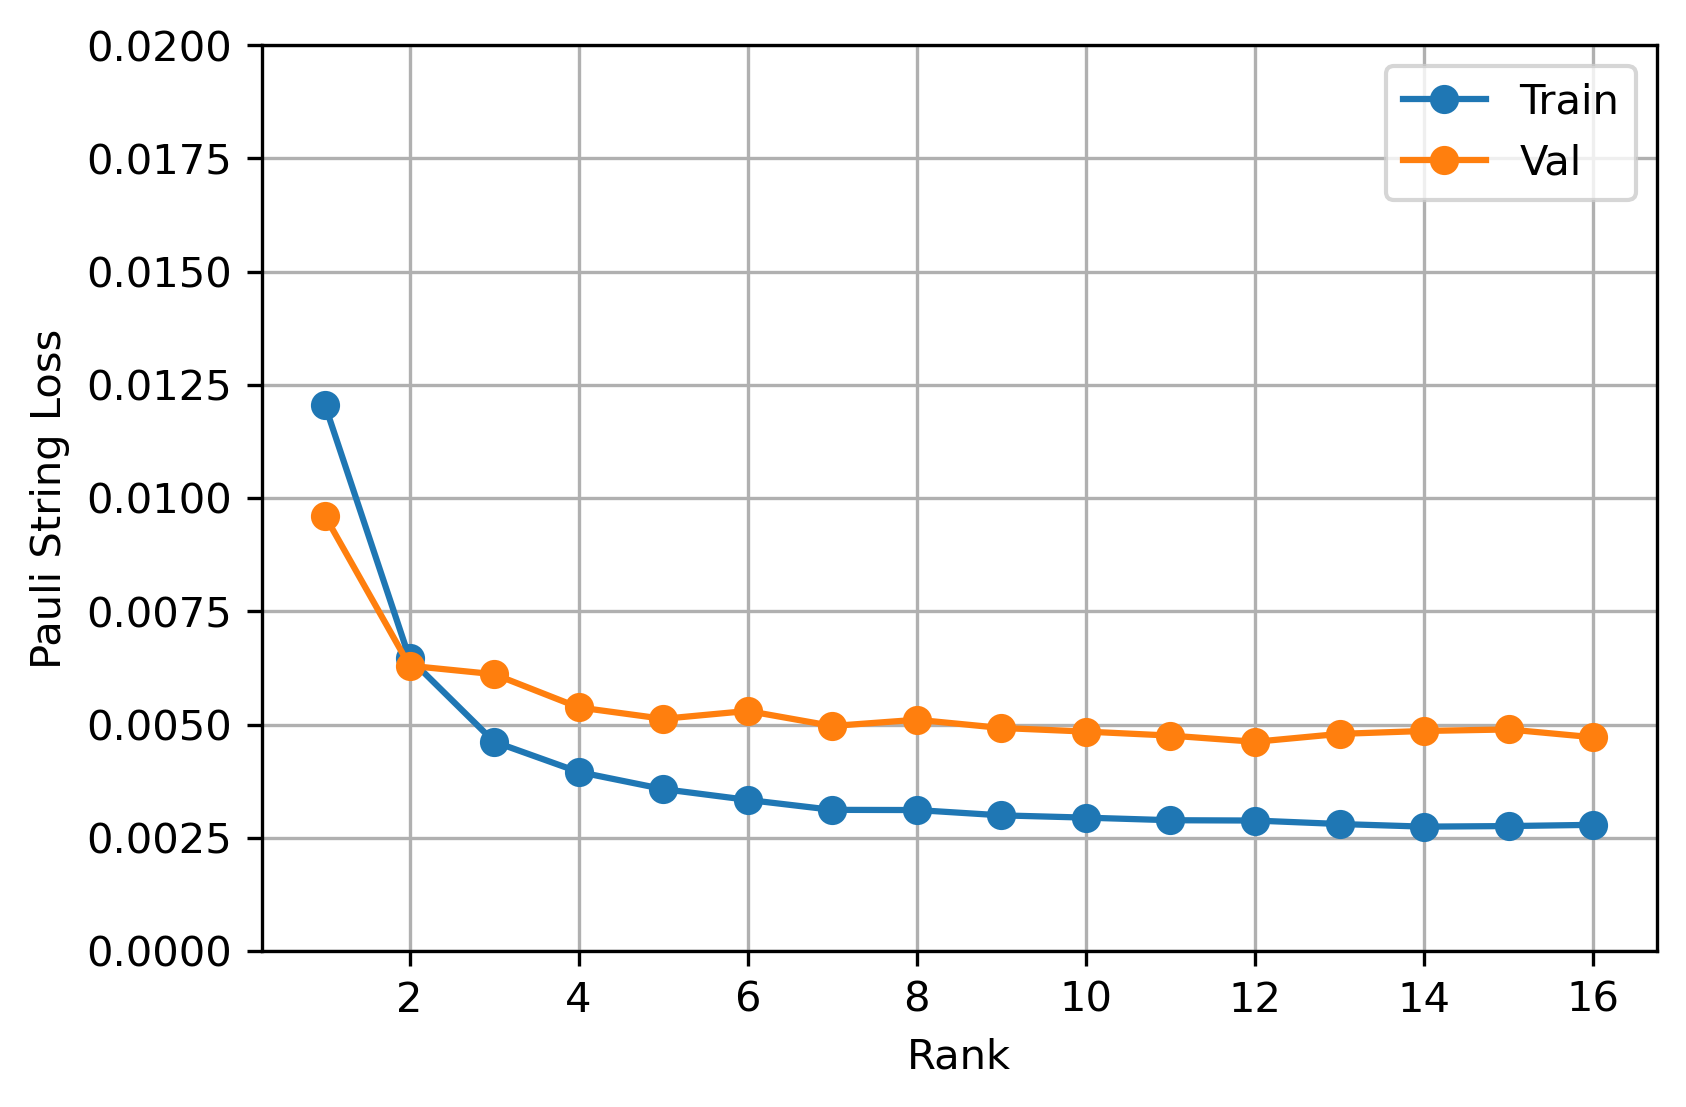

In [75]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
plt.grid()
plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")

plt.plot(list(range(1,17)), loss_train1, "-o")
plt.plot(list(range(1,17)), loss_val1, "-o")

plt.ylim([0, 0.02])
plt.legend(["Train","Val"])
plt.show()

fig.savefig("../../latex/figures/variational_threeLayer_loss.pdf")

### Six Layers

In [61]:
inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational_6.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

targets_map_train = targets_map[:700]
targets_map_val = targets_map[700:]

inputs_map_train = [inputs_map[0][:700], inputs_map[1][:700]]
inputs_map_val = [inputs_map[0][700:], inputs_map[1][700:]]

n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                num_iter = 300,
                verbose = False,
                )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                 )

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583107348377e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.000441691987107735


In [62]:
model_list = []
for i in range(1, 17):
    kraus_model = KrausMap(d = d, 
                           rank = i,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 1000,
                verbose = False,
                )
    
    model_list.append(model)
    
loss_train2 = [model.loss_train[-1] for model in model_list]
loss_val2 = [model.loss_val[-1] for model in model_list]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.032380270011584715 0.032323747246643


  0%|          | 0/1000 [00:00<?, ?it/s]

0.01411437371934372 0.01734916900316248


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008453864382866954 0.011261306746778395


  0%|          | 0/1000 [00:00<?, ?it/s]

0.006575696208181863 0.00823986434560974


  0%|          | 0/1000 [00:00<?, ?it/s]

0.004902144864007642 0.007053003593744769


  0%|          | 0/1000 [00:00<?, ?it/s]

0.004193438346397867 0.006484576823757731


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00391809616335529 0.0056921345302189145


  0%|          | 0/1000 [00:00<?, ?it/s]

0.003629306019943419 0.005929017963070466


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0035092454034572843 0.005471963763534684


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0032241292837920086 0.005008070663481123


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0031183463294169288 0.004579224827993944


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002941422561094025 0.004496673314333702


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0029616507739676835 0.004573334848372219


  0%|          | 0/1000 [00:00<?, ?it/s]

0.002915008877612943 0.004670417439079392


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028341712157718218 0.004135439996424771


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0028327784964280334 0.00436577675553057


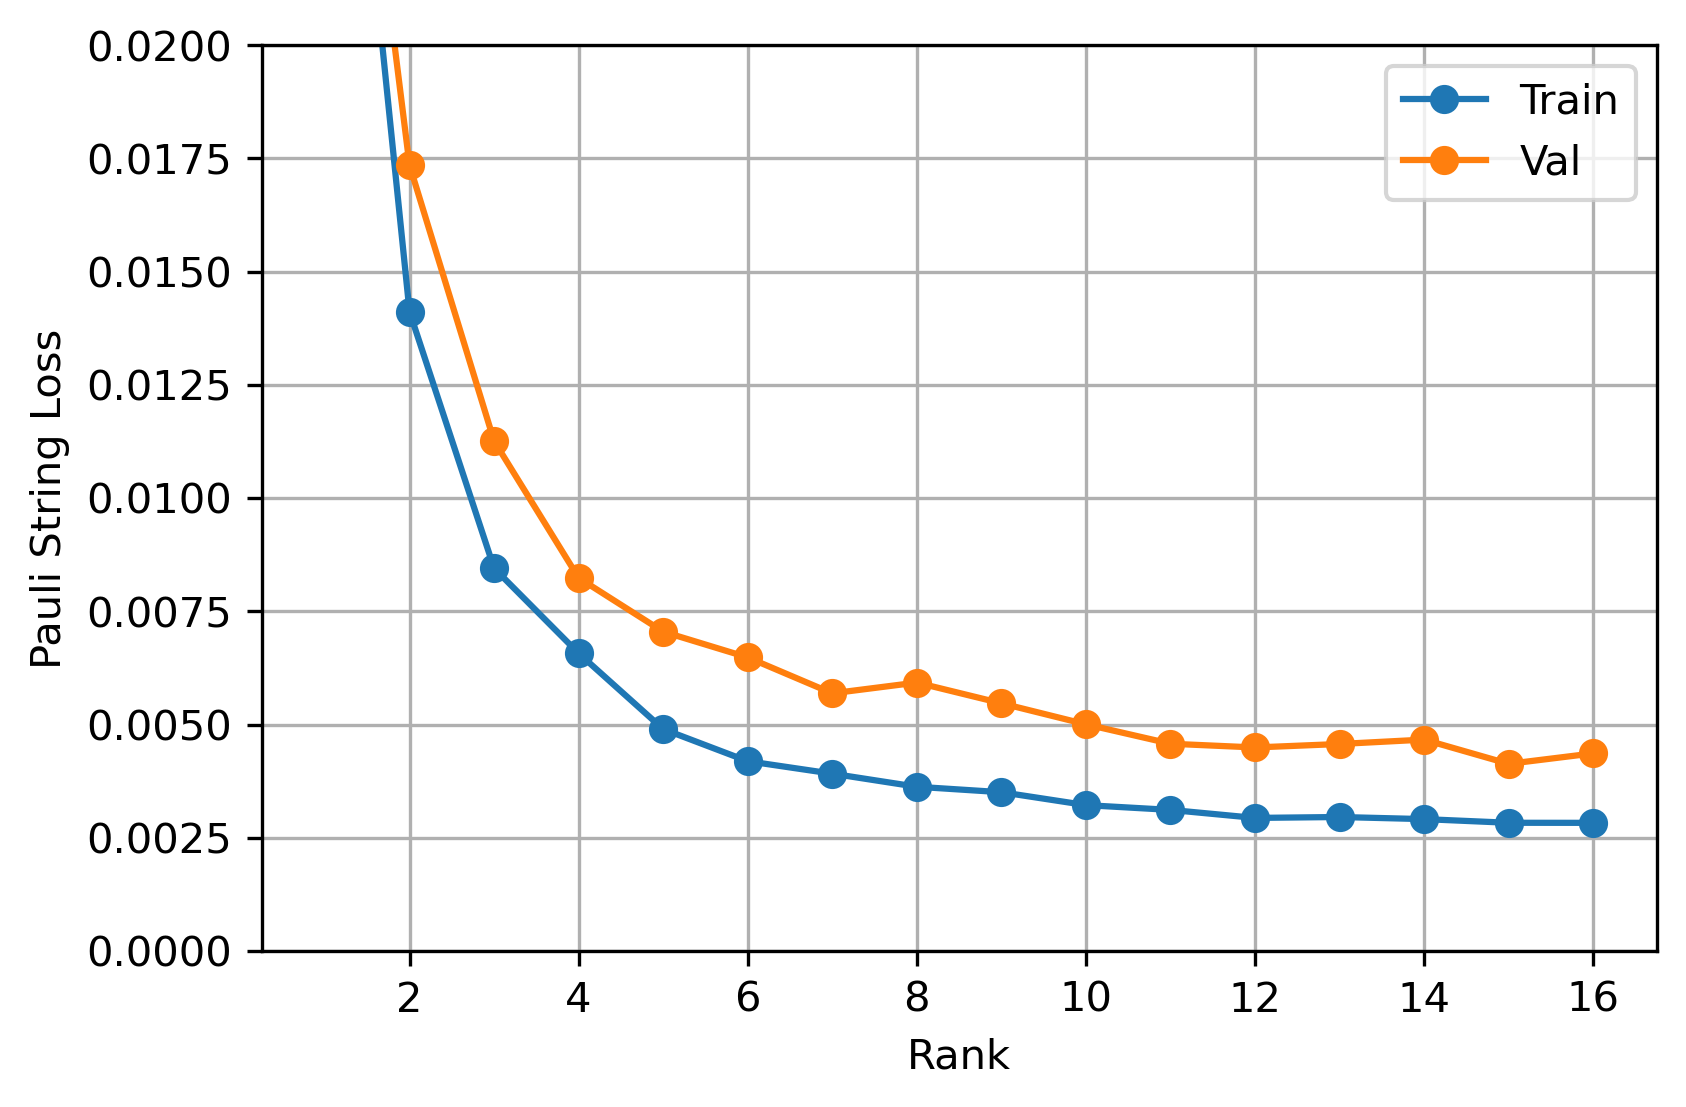

In [74]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")
plt.plot(list(range(1,17)), loss_train2, "-o")
plt.plot(list(range(1,17)), loss_val2, "-o")
plt.grid()
plt.ylim([0, 0.02])
plt.legend(["Train","Val"])
fig.savefig("../../latex/figures/variational_sixLayer_loss.pdf")

plt.show()

### Nine Layers

In [64]:
inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational_9.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

targets_map_train = targets_map[:700]
targets_map_val = targets_map[700:]

inputs_map_train = [inputs_map[0][:700], inputs_map[1][:700]]
inputs_map_val = [inputs_map[0][700:], inputs_map[1][700:]]

n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                num_iter = 300,
                verbose = False,
                )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 verbose = False,
                 )

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583107348377e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.0004837367226490718


In [76]:
model_list = []
for i in range(1, 17):
    kraus_model = KrausMap(d = d, 
                           rank = i,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs_map_train,
                targets = targets_map_train,
                inputs_val = inputs_map_val,
                targets_val = targets_map_val,
                num_iter = 2000,
                verbose = False,
                )
    
    model_list.append(model)
    
loss_train3 = [model.loss_train[-1] for model in model_list]
loss_val3 = [model.loss_val[-1] for model in model_list]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0680211043902595 0.05628604580787126


  0%|          | 0/2000 [00:00<?, ?it/s]

0.02612231562955877 0.0324040053129392


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014859069692352197 0.0212721185719287


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009824840411264723 0.01697492750282975


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007662987948843255 0.013849694801398351


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006403876166107761 0.012044835195252625


  0%|          | 0/2000 [00:00<?, ?it/s]

0.005561595282208377 0.0121149367775444


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004681280006540134 0.010303794969517938


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0043605206666996925 0.009447748124445527


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004056311345683067 0.009677059310059305


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003838179482806089 0.00944100927394364


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003698749896050301 0.008802647047665127


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003608115626682004 0.008286720465393544


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0034863705785833613 0.008278810354004304


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003389357017551611 0.007891124605111545


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003393368554898616 0.008217247631636266


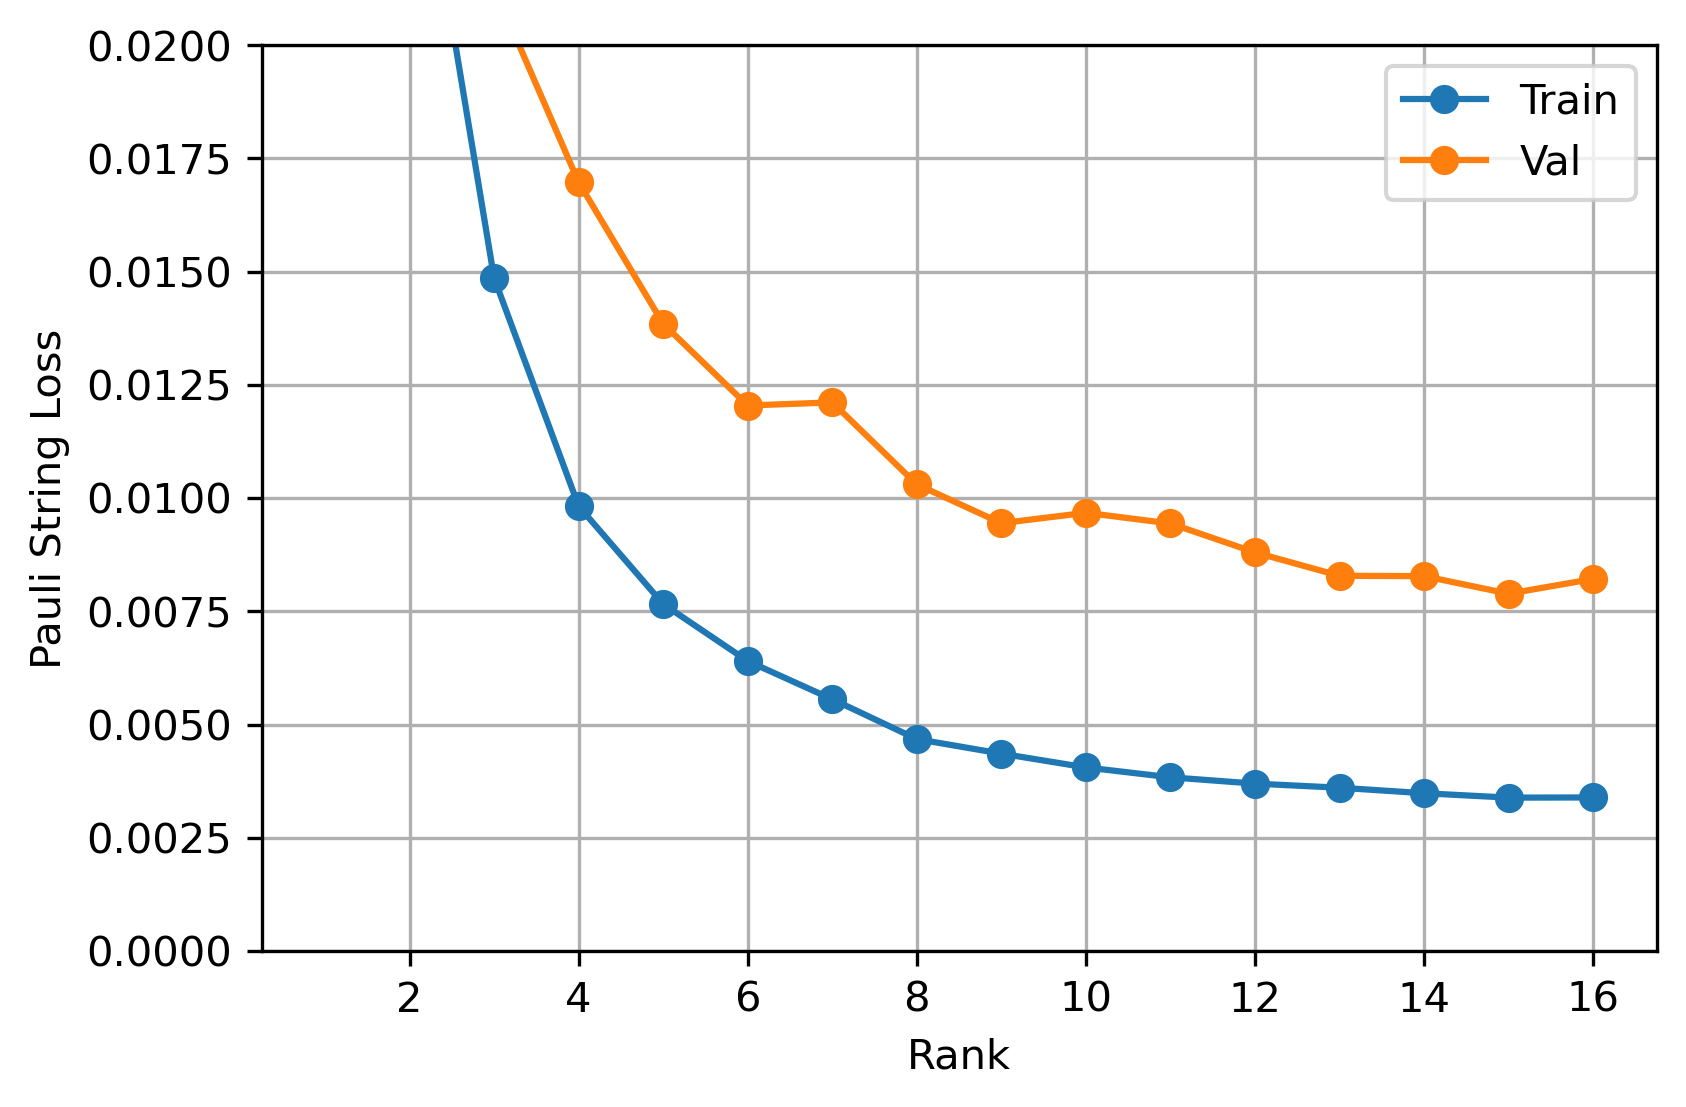

In [77]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.xlabel("Rank")
plt.ylabel("Pauli String Loss")
plt.plot(list(range(1,17)), loss_train3, "-o")
plt.plot(list(range(1,17)), loss_val3, "-o")
plt.ylim([0, 0.02])
plt.grid()
plt.legend(["Train","Val"])
fig.savefig("../../latex/figures/variational_nineLayer_loss.pdf")

plt.show()